## Oppia Gitter Chatroom Report

Requirements:
  1. Npm module:  [gitter-export-room](https://www.npmjs.com/package/gitter-export-room/tutorial)
  2. Scikit-learn
  3. Pandas
  4. NLTK
  
   Specifications:
    1. oppia-chatroom-id : 561f4f4416b6c7089cb70f23 
    2. token :  a5d7930a73eeaaed398112b1c18735db2da5a8cc

In [1]:
# Importing Libraries
import time
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
stops = set(stopwords.words("english"))

In [2]:
start = time.time()
print("Exporting Oppia Gitter Chat")
!gitter-export-room id 561f4f4416b6c7089cb70f23 --token a5d7930a73eeaaed398112b1c18735db2da5a8cc > ../data/oppia_chat_2018_2_19.json
end = time.time()
print("Elapsed Time: ",end - start)

Exporting Oppia Gitter Chat
..................................................................................................................................................
('Elapsed Time: ', 242.80704879760742)


In [3]:
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = text
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt

def Extract_Username(column):
    temp_dict = dict(column)
    return temp_dict['username']

def Extract_Issue_Number(column):
    if column != []:
        temp_dict = dict(column[0])
        return temp_dict['number']
    else:
        return np.nan 
    
def Extract_URLs(column):
    if column != []:
        temp_dict = dict(column[0])
        return temp_dict[u'url']
    else:
        return np.nan
    
def Mentions(column):
    mention_lst = ', '.join(re.findall("@([a-z0-9_]+)", column, re.I))
    return mention_lst

In [4]:
chat = pd.read_json('../data/oppia_chat_2018_2_19.json')

In [5]:
chat.head()

,editedAt,fromUser,html,id,issues,mentions,meta,readBy,sent,status,text,unread,urls,v
0,NaN,"{u'username': u'bansalnitish', u'gv': u'4', u'...","<span data-link-type=""mention"" data-screen-nam...",5a7e29e4f283b8e5464114d8,"[{u'repo': u'oppia/oppia', u'number': u'4670'}]","[{u'userIds': [], u'userId': u'58225c21d73408c...",[],38,2018-02-09T23:08:20.299Z,NaN,@tjiang11 @seanlip Please review https://gith...,False,[],1
1,NaN,"{u'username': u'anookeen', u'gv': u'4', u'disp...","<span data-link-type=""mention"" data-screen-nam...",5a7ea13886ef1bb141901c20,[],"[{u'userIds': [], u'userId': u'582b27a4d73408c...",[],37,2018-02-10T07:37:28.826Z,NaN,@harsha444 try running your tests in virtual ...,False,[],1
2,NaN,"{u'username': u'anookeen', u'gv': u'4', u'disp...",use these commands virtualenv ./my-env<br> sou...,5a7ea1be4a6b0dd32bb1bb78,[],[],[],38,2018-02-10T07:39:42.081Z,NaN,use these commands virtualenv ./my-env\n sourc...,False,[],1
3,NaN,"{u'username': u'anookeen', u'gv': u'4', u'disp...","and then run the tests <span data-link-type=""m...",5a7ea1cde217167e2c67194f,[],"[{u'userIds': [], u'userId': u'582b27a4d73408c...",[],38,2018-02-10T07:39:57.009Z,NaN,and then run the tests @harsha444,False,[],1
4,NaN,"{u'username': u'arnab1896', u'gv': u'4', u'dis...",i&#39;m thinking of setting up a static webpag...,5a7f09154a6b0dd32bb36d7c,[],[],[],38,2018-02-10T15:00:37.803Z,NaN,i'm thinking of setting up a static webpage us...,False,[],1


The exported chat data is in JSON format. Unfortunately, pandas didnt process the inner dictionaries. The Gitter API defines the feature columns as shown below

### Message schema

`` id: ID of the message.
text: Original message in plain-text/markdown.
html: HTML formatted message.
sent: ISO formatted date of the message.
editedAt: ISO formatted date of the message if edited.
fromUser: (User)[user-resource] that sent the message.
unread: Boolean that indicates if the current user has read the message.
readBy: Number of users that have read the message.
urls: List of URLs present in the message.
mentions: List of @Mentions in the message.
issues: List of #Issues referenced in the message.
meta: Metadata. This is currently not used for anything.
v: Version.
gv: Stands for "Gravatar version" and is used for cache busting.``


Lets clean the data and extract additional features for data analysis - 

1. username
2. issue number mentioned in the text/chat
3. url in the text
4. user mention / Fill empty string is None
5. number of Question marks
6. date and time features

In [6]:
chat = chat[chat.columns[::-1]]
text = chat['text'].copy()

### Feature Engineering and Cleaning  Data

In [7]:
chat['username'] = chat['fromUser'].apply(Extract_Username)
chat['issue number'] = chat['issues'].apply(Extract_Issue_Number)
chat['url'] = chat['urls'].apply(Extract_URLs)
chat['mentions'] = chat['text'].apply(Mentions)
chat['mentions'].replace(to_replace ='', value= np.nan, inplace = True )
chat['sent'] = pd.to_datetime(chat['sent'])
chat['editedAt'] = pd.to_datetime(chat['editedAt'])
chat['question_marks'] = chat['text'].apply(lambda comment: comment.count('?'))
chat['Year'] = chat['sent'].dt.year
chat['Month'] = chat['sent'].dt.month
chat['Quarter'] = chat['sent'].dt.quarter
chat['DOW'] = chat['sent'].dt.dayofweek
chat['Day'] = chat['sent'].dt.day
chat['Hour'] = chat['sent'].dt.hour

cols_to_drop = ["fromUser","html","issues","meta","status","unread","urls"]
chat.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
chat['text'] = chat['text'].apply(cleanData, lowercase = True, remove_stops = True, stemming = True)

In [9]:
chat.head()

,v,text,sent,readBy,mentions,id,editedAt,username,issue number,url,question_marks,Year,Month,Quarter,DOW,Day,Hour
0,1,tjiang11 seanlip pleas review httpsgithubcomop...,2018-02-09 23:08:20.299,38,"tjiang11, seanlip",5a7e29e4f283b8e5464114d8,NaT,bansalnitish,4670,NaN,0,2018,2,1,4,9,23
1,1,harsha444 tri run test virtual environ,2018-02-10 07:37:28.826,37,harsha444,5a7ea13886ef1bb141901c20,NaT,anookeen,NaN,NaN,0,2018,2,1,5,10,7
2,1,use command virtualenv myenv sourc activ myenv,2018-02-10 07:39:42.081,38,NaN,5a7ea1be4a6b0dd32bb1bb78,NaT,anookeen,NaN,NaN,0,2018,2,1,5,10,7
3,1,run test harsha444,2018-02-10 07:39:57.009,38,harsha444,5a7ea1cde217167e2c67194f,NaT,anookeen,NaN,NaN,0,2018,2,1,5,10,7
4,1,im think set static webpag use github page ded...,2018-02-10 15:00:37.803,38,NaN,5a7f09154a6b0dd32bb36d7c,NaT,arnab1896,NaN,NaN,1,2018,2,1,5,10,15


Nice! 
Now we have usernames and issue numbers and other useful data

### ReadBy Analysis

In [10]:
chat_df = chat

In [11]:
chat_df.pivot_table(values='readBy',
                                index='Year', columns='Month')

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,5.900000,5.750000
2016,6.758224,9.888889,17.374286,15.445428,14.090564,11.590074,12.437037,11.676157,13.797521,12.675229,24.294574,23.179487
2017,20.464135,27.579926,23.435028,21.584582,19.333333,11.228112,15.712963,17.109756,23.470588,22.076471,22.762162,24.529052
2018,29.000000,37.385057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,u'ReadBy Count Heatmap Timeline')

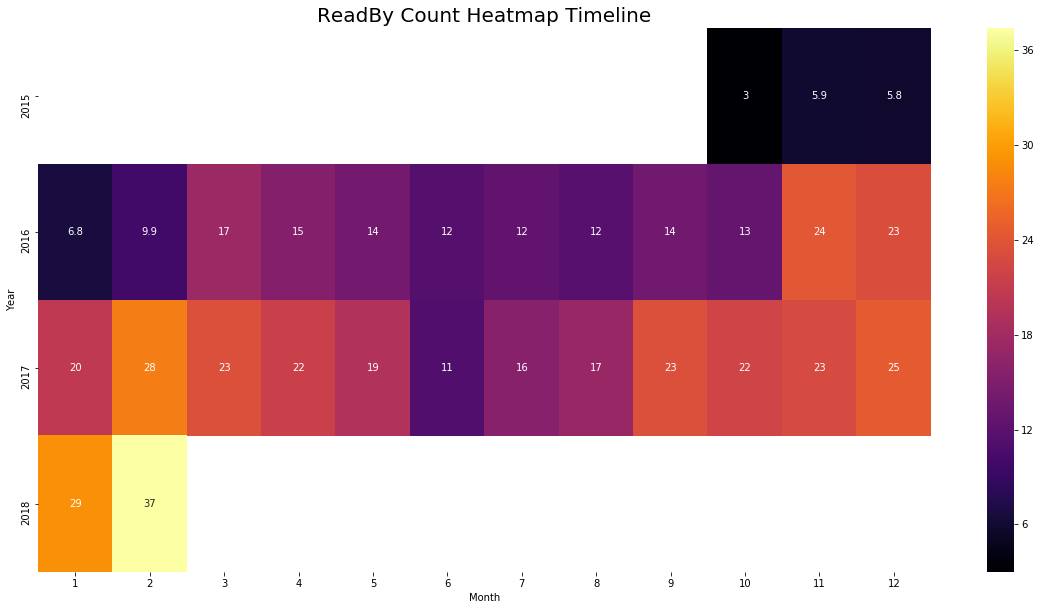

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(chat_df.pivot_table(values='readBy',
                                index='Year', columns='Month') , cmap='inferno', annot = True)
plt.title("ReadBy Count Heatmap Timeline", fontsize=20)

### GroupBy Hour 

In [13]:
chat_df.groupby(by='Hour').mean().head()

,v,readBy,question_marks,Year,Month,Quarter,DOW,Day
Hour,,,,,,,,
0,1.038690,14.717262,0.252976,2016.520833,5.235119,1.964286,2.428571,11.952381
1,1.028754,16.776358,0.271565,2016.447284,5.060703,2.076677,2.527157,16.057508
2,1.017167,13.716738,0.268240,2016.650215,5.976395,2.214592,3.150215,17.412017
3,1.018242,13.786070,0.240464,2016.484245,6.422886,2.436153,3.616915,13.129353
4,1.026860,11.878099,0.188017,2016.359504,6.728306,2.529959,3.287190,9.788223


Text(0,0.5,u'Number of Questions')

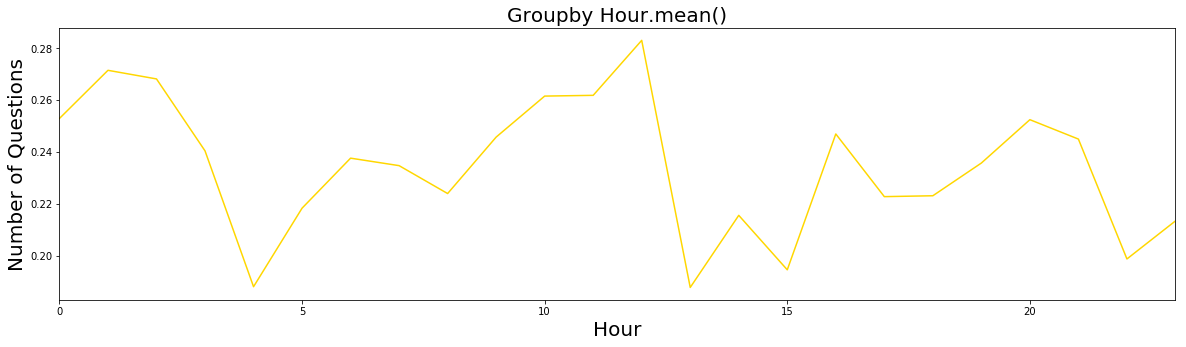

In [14]:
plt.title('Groupby Hour.mean()', fontsize=20)
chat_df.groupby(by='Hour').mean()['question_marks'].plot(figsize=(20,5), kind='line', color='gold')
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Number of Questions', fontsize=20)

### GroupBy Day Of Week 

Text(0,0.5,u'Number of Questions')

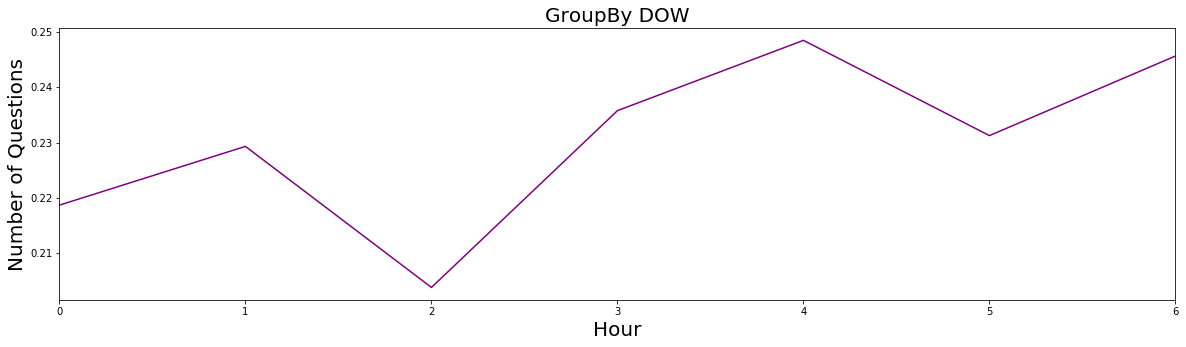

In [15]:
plt.title('GroupBy DOW', fontsize=20)
chat_df.groupby(by='DOW').mean()['question_marks'].plot(figsize=(20,5), kind='line', color='purple')
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Number of Questions', fontsize=20)

Text(0,0.5,u'Number of Questions')

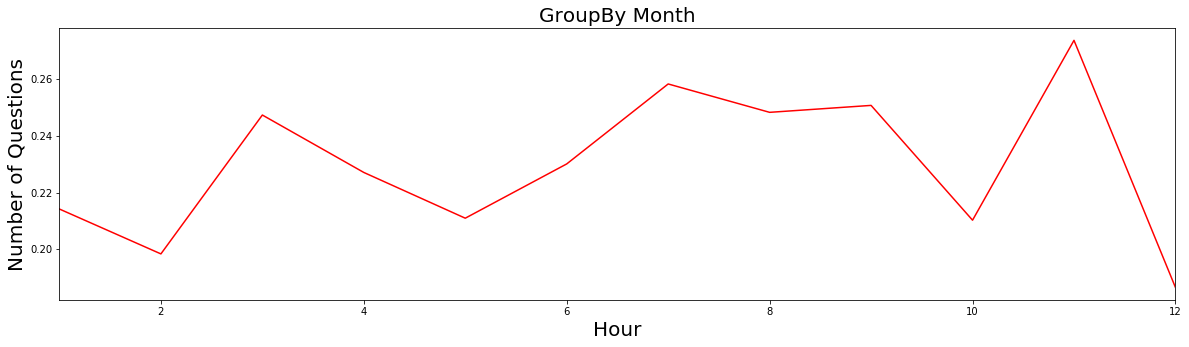

In [16]:
plt.title('GroupBy Month', fontsize=20)
chat_df.groupby(by='Month').mean()['question_marks'].plot(figsize=(20,5), kind='line', color='red')
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Number of Questions', fontsize=20)

## TF-IDF Vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

In [18]:
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,4), min_df=5)
tfidfdata = tfidfvec.fit_transform(chat_df['text'])

In [19]:
feature_names = tfidfvec.get_feature_names()
len(feature_names)

4490

In [20]:
pd.DataFrame(feature_names).transpose()

,0,1,2,3,4,5,6,7,8,9,...,4480,4481,4482,4483,4484,4485,4486,4487,4488,4489
0,10,10 min,100,101,1053,1053 endhead,1053 endhead selfsendoutputmessagebodi,1053 endhead selfsendoutputmessagebodi file,11,12,...,youv got,yuicompressor248jar,yuicompressor248jar oppiatoolsyuicompressor248,yup,zhengxit,zip,zip file,zip file check,zip file check whether,zip file download


In [21]:
# create dataframe for features
tfidf_df = pd.DataFrame(tfidfdata.todense())
tfidf_df.columns = feature_names

In [22]:
X = tfidf_df

In [23]:
from tqdm import tqdm

In [24]:
# k means determine k
distortions = []
K = range(1,6)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

100%|██████████| 5/5 [16:05<00:00, 193.08s/it]


In [25]:
K

[1, 2, 3, 4, 5]

In [26]:
distortions

[0.9551161135067872,
 0.9487294145751778,
 0.9437889941209783,
 0.9410789283679125,
 0.9413825900241848]

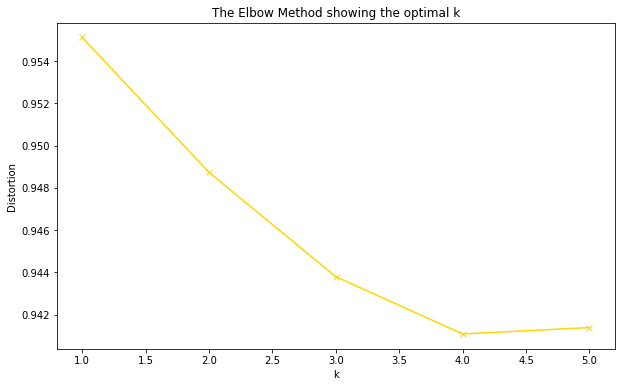

In [27]:
# Plot the elbow
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-', color='gold')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

NameError: name 'KMeans' is not defined

In [28]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X=tfidf_df)
cluster = pd.DataFrame(chat[['text','mentions','username','question_marks']])
cluster['cluster'] = kmeans.predict(tfidf_df)
cluster['text']  = chat['text']

In [29]:
cluster.head()

,text,mentions,username,question_marks,cluster
0,tjiang11 seanlip pleas review httpsgithubcomop...,"tjiang11, seanlip",bansalnitish,0,0
1,harsha444 tri run test virtual environ,harsha444,anookeen,0,0
2,use command virtualenv myenv sourc activ myenv,NaN,anookeen,0,0
3,run test harsha444,harsha444,anookeen,0,0
4,im think set static webpag use github page ded...,NaN,arnab1896,1,0


In [30]:
import matplotlib.gridspec as gridspec 
from wordcloud import WordCloud , STOPWORDS
from PIL import Image
import matplotlib_venn as venn

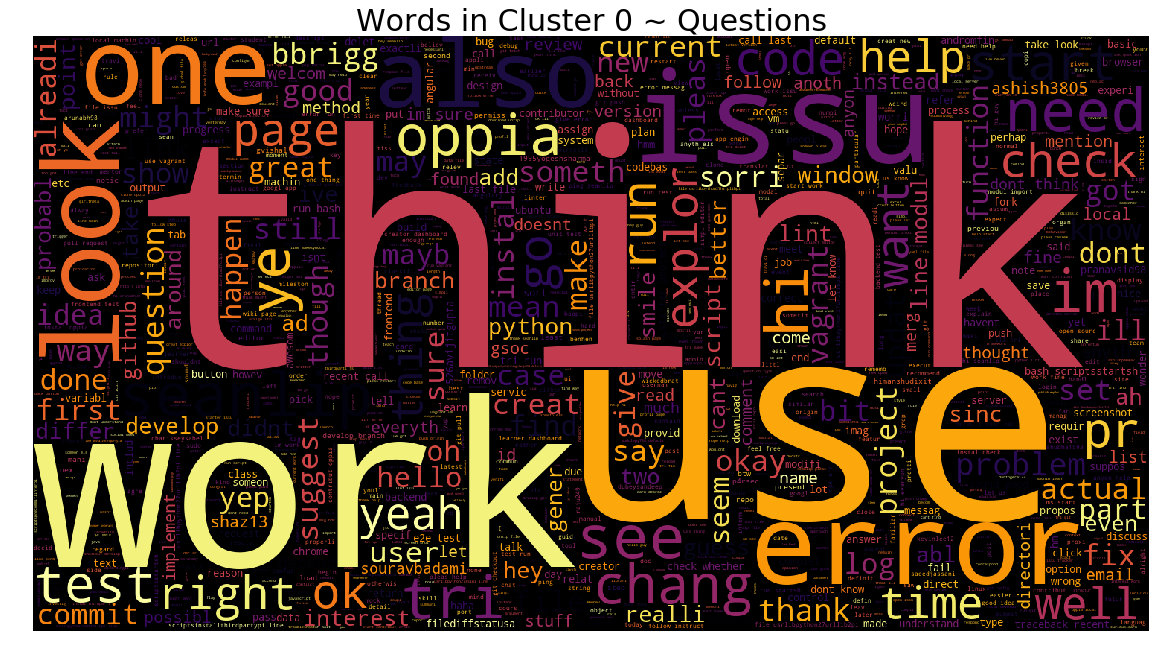

In [31]:
stopword=set(STOPWORDS)
text=cluster[cluster['cluster'] == 0].text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopword, height=800, width=1500)
wc.generate(" ".join(text))
plt.figure(figsize=(20,12))
plt.axis("off")
plt.title("Words in Cluster 0 ~ Questions" , fontsize=30)
plt.imshow(wc.recolor(colormap= 'inferno' , random_state=17), alpha=1)
plt.show()

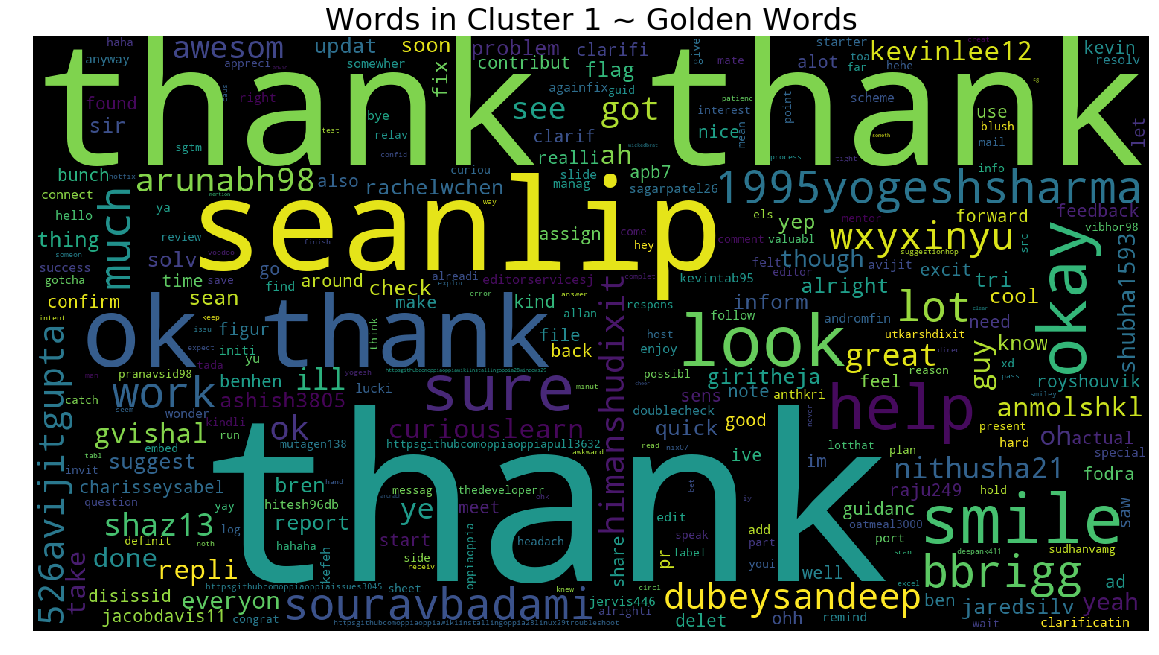

In [32]:
stopword=set(STOPWORDS)
text=cluster[cluster['cluster'] == 1].text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopword, height=800, width=1500)
wc.generate(" ".join(text))
plt.figure(figsize=(20,12))
plt.axis("off")
plt.title("Words in Cluster 1 ~ Golden Words" , fontsize=30)
plt.imshow(wc.recolor( random_state=17), alpha=1)
plt.show()

In [33]:
cluster[cluster['question_marks'] > 0].head(20)

,text,mentions,username,question_marks,cluster
4,im think set static webpag use github page ded...,NaN,arnab1896,1,0
8,android project oppia,NaN,anandgoswami,1,0
9,anyon guid write unit test explorationsummaryb...,NaN,anookeen,1,0
11,wickedbrat run test,WickedBrat,anookeen,1,0
12,order check output,NaN,anookeen,1,0
25,hey gsoc idea oppia,NaN,darthgera123,1,0
27,wickedbrat project look,WickedBrat,darthgera123,1,0
43,hi divyadeep singh 3rd year engin student hbtu...,NaN,divyadeep1,1,0
48,still want restart test paroothisumit,paroothisumit,WickedBrat,1,0
53,hello im rohit 3rd uear undergradu iit madra i...,NaN,RohitB97,1,0


In [34]:
cluster[cluster['question_marks'] > 0].cluster.value_counts()

0    3064
1       5
Name: cluster, dtype: int64

In [35]:
print "Number of Questions asked:" , chat[chat['question_marks']>0].text.shape[0]
print "Total number of comments:" , chat.shape[0]
print "Percentage of Questions:", (chat[ chat['question_marks']>0].text.shape[0] / float(chat.shape[0]))*100.0

Number of Questions asked: 3069
Total number of comments: 14567
Percentage of Questions: 21.0681677765


** Yay!  **
**We have successfully classified texts into 2 clusters. The cluster 0 = Text with questions and cluster 1 comes under gratitude and FYI texts**

In [36]:
MostActiveUsers = pd.DataFrame(chat_df.username.value_counts()[:10]).reset_index()

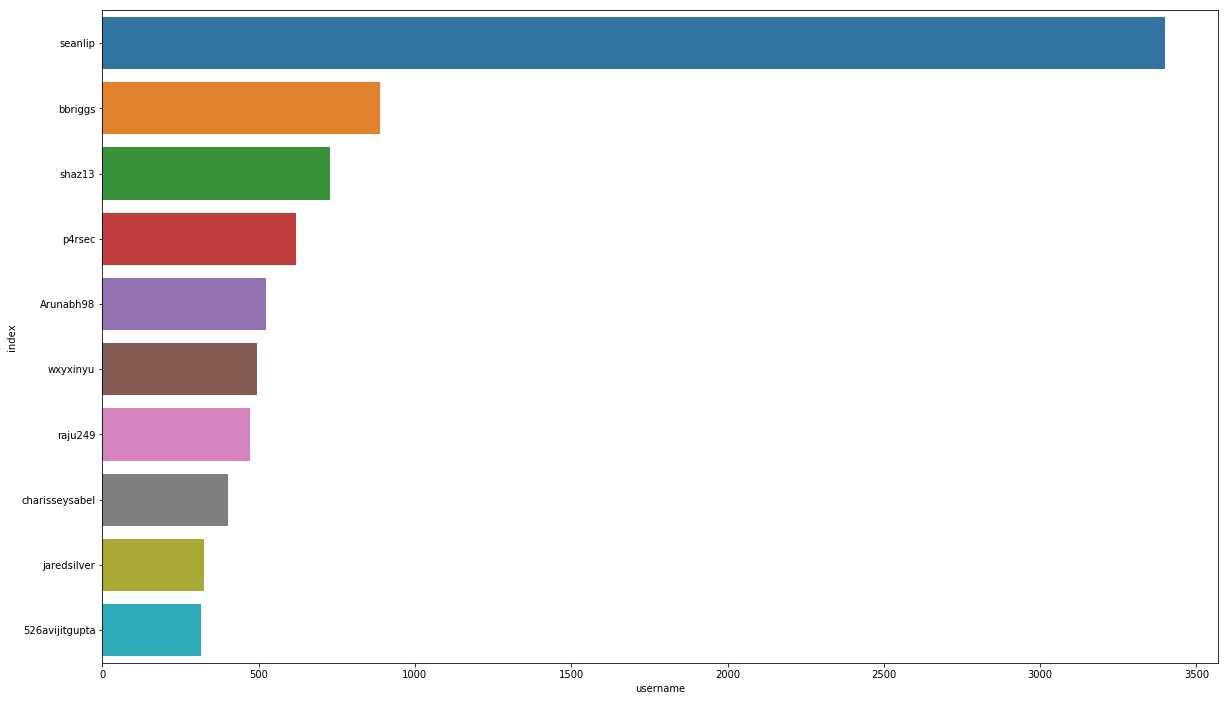

In [37]:
plt.figure(figsize=(20,12))
sns.barplot(y=MostActiveUsers['index'], x=MostActiveUsers.username )

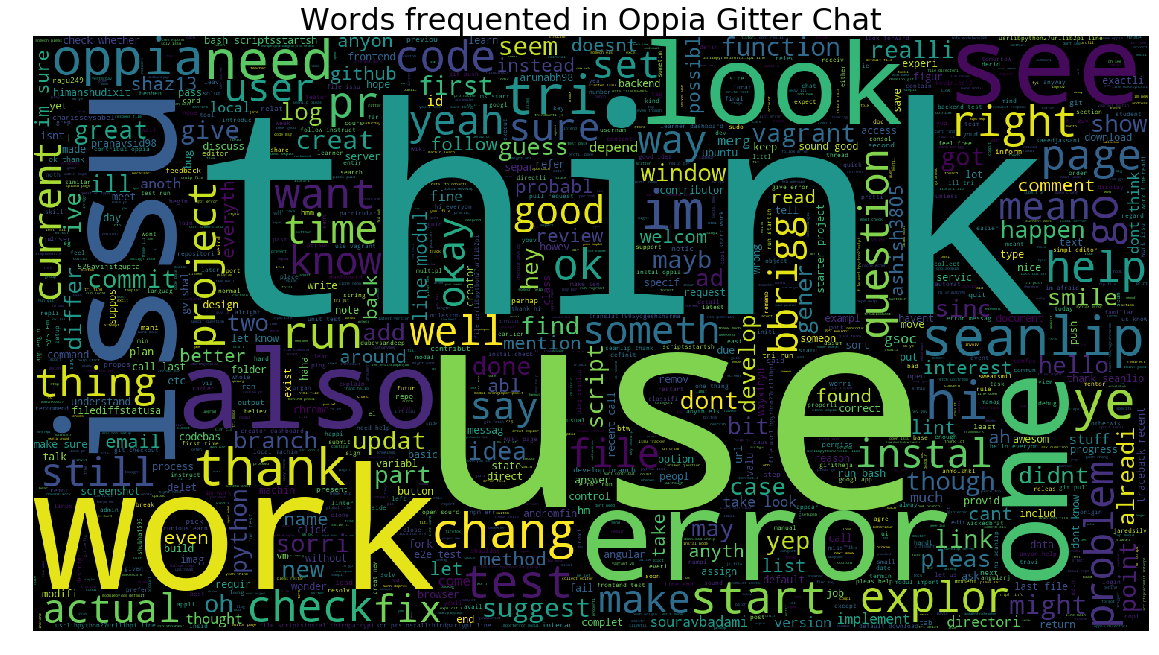

In [38]:
stopword=set(STOPWORDS)
text=chat_df.text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopword, height=800, width=1500)
wc.generate(" ".join(text))
plt.figure(figsize=(20,12))
plt.axis("off")
plt.title("Words frequented in Oppia Gitter Chat", fontsize=30)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=1)
plt.show()

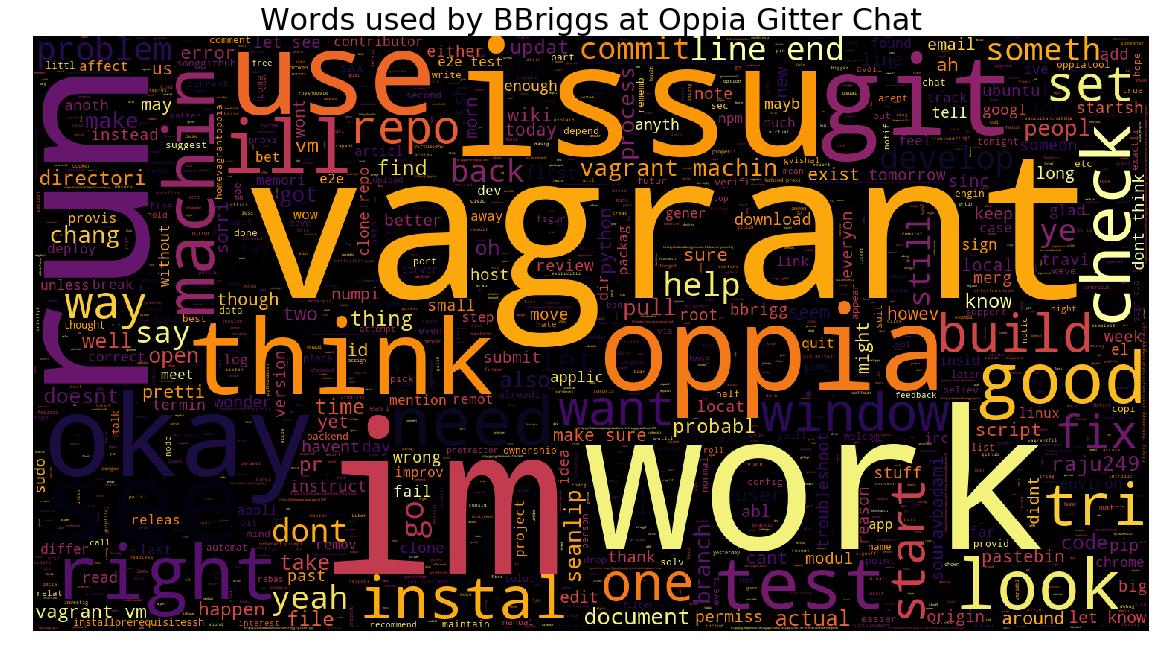

In [39]:
text=chat_df[chat_df['username'] == 'bbriggs'].text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopword, height=800, width=1500)
wc.generate(" ".join(text))
plt.figure(figsize=(20,12))
plt.axis("off")
plt.title("Words used by BBriggs at Oppia Gitter Chat", fontsize=30)
plt.imshow(wc.recolor(colormap= 'inferno' , random_state=17), alpha=1)
plt.show()

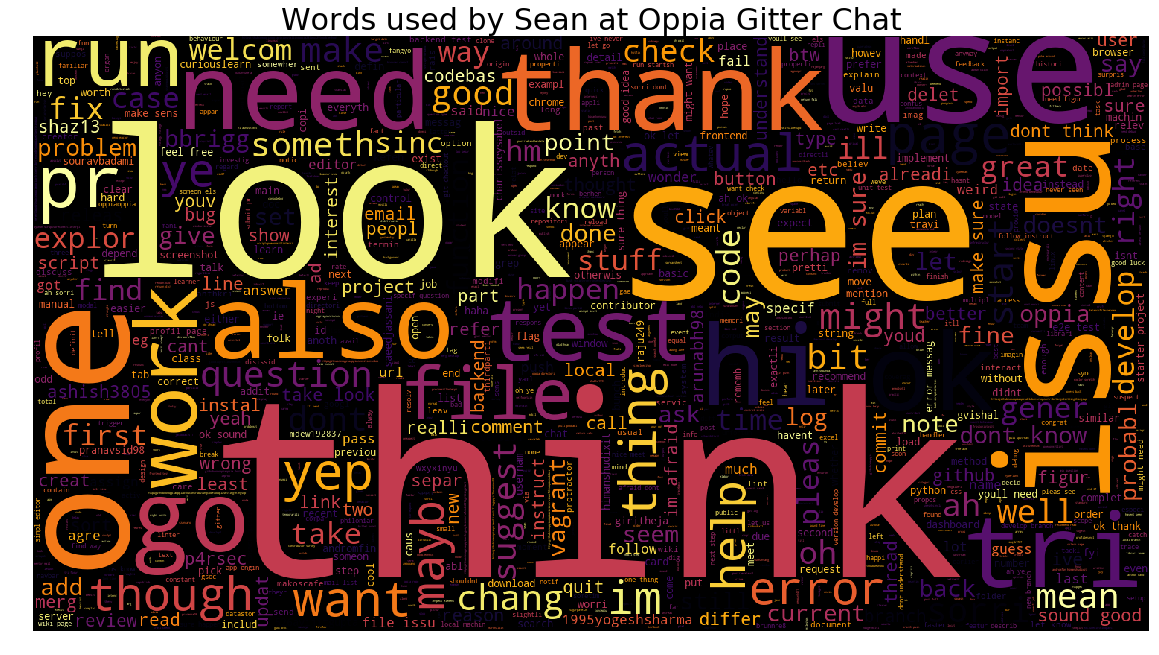

In [40]:
text=chat_df[chat_df['username'] == 'seanlip'].text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopword, height=800, width=1500)
wc.generate(" ".join(text))
plt.figure(figsize=(20,12))
plt.axis("off")
plt.title("Words used by Sean at Oppia Gitter Chat", fontsize=30)
plt.imshow(wc.recolor(colormap= 'inferno' , random_state=17), alpha=1)
plt.show()

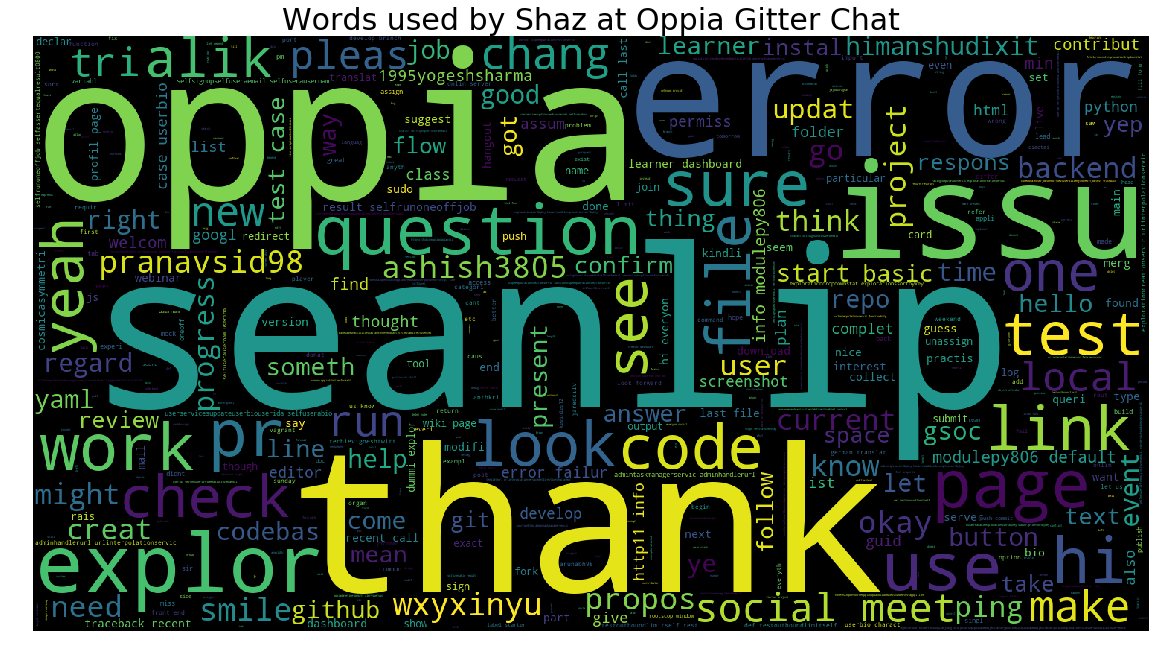

In [41]:
text=chat_df[chat_df['username'] == 'shaz13'].text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopword, height=800, width=1500)
wc.generate(" ".join(text))
plt.figure(figsize=(20,12))
plt.axis("off")
plt.title("Words used by Shaz at Oppia Gitter Chat", fontsize=30)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=1)
plt.show()

Text(0,0.5,u'Number of Questions')

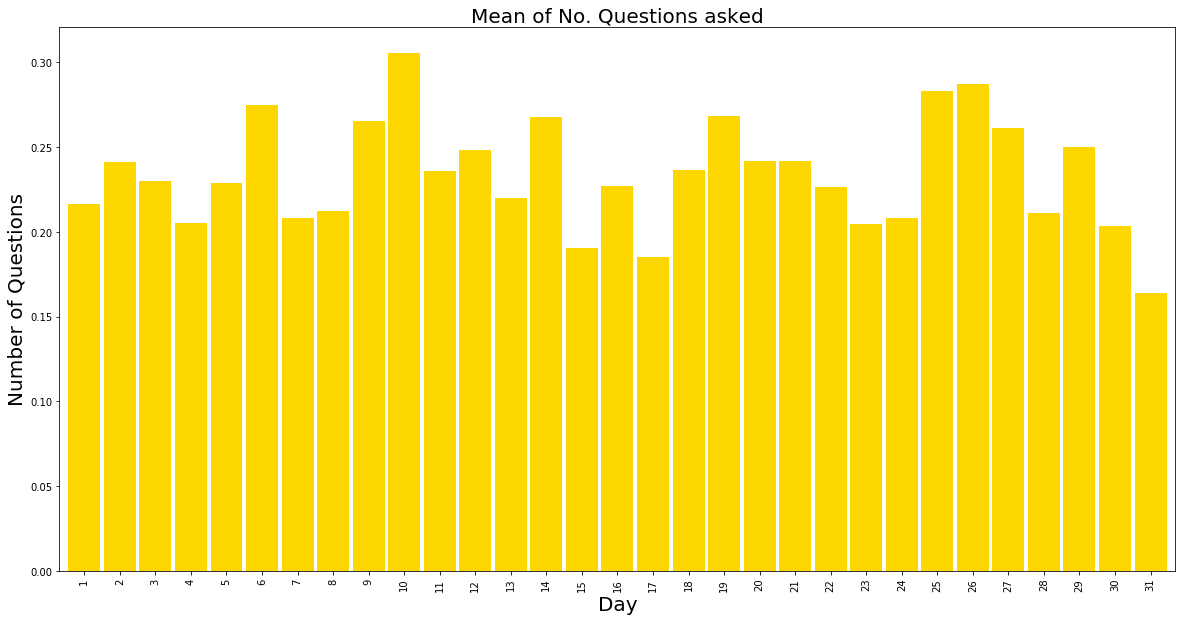

In [42]:
plt.title('Mean of No. Questions asked', fontsize=20)
chat_df.groupby(by='Day').mean()['question_marks'].plot(figsize=(20,10), kind='bar', width=.9, color='gold')
plt.xlabel('Day', fontsize=20)
plt.ylabel('Number of Questions', fontsize=20)

Text(0,0.5,u'Number of Questions')

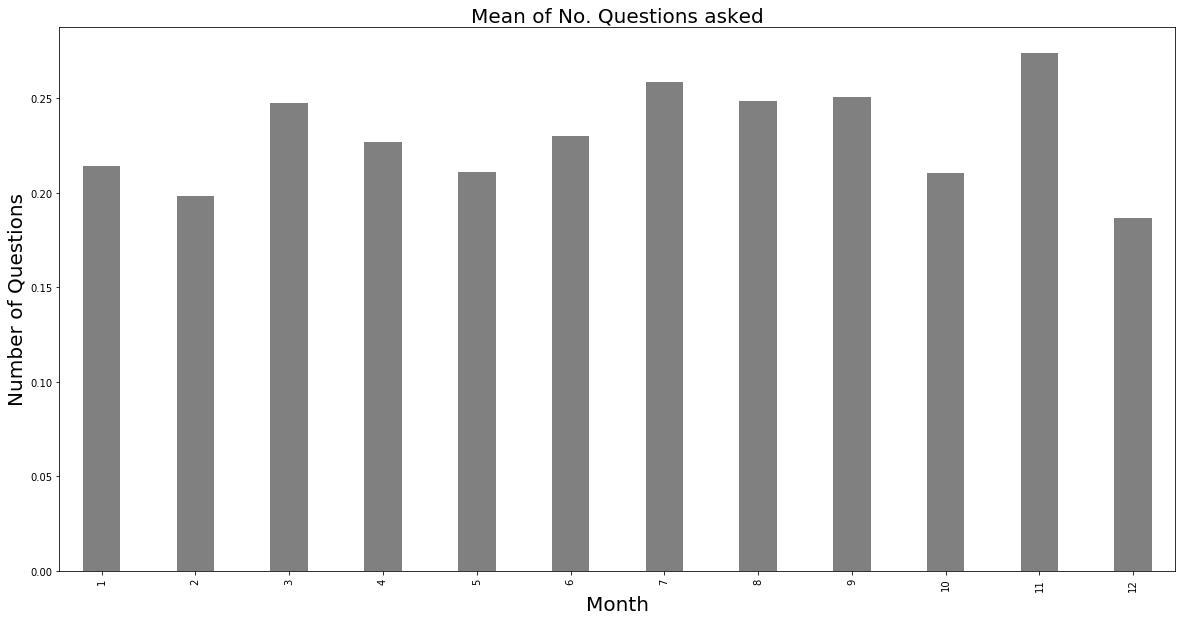

In [43]:
plt.title('Mean of No. Questions asked', fontsize=20)
chat_df.groupby(by='Month').mean()['question_marks'].plot(figsize=(20,10), kind='bar', width= .4, color='grey')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of Questions', fontsize=20)

Text(0,0.5,u'Number of Questions')

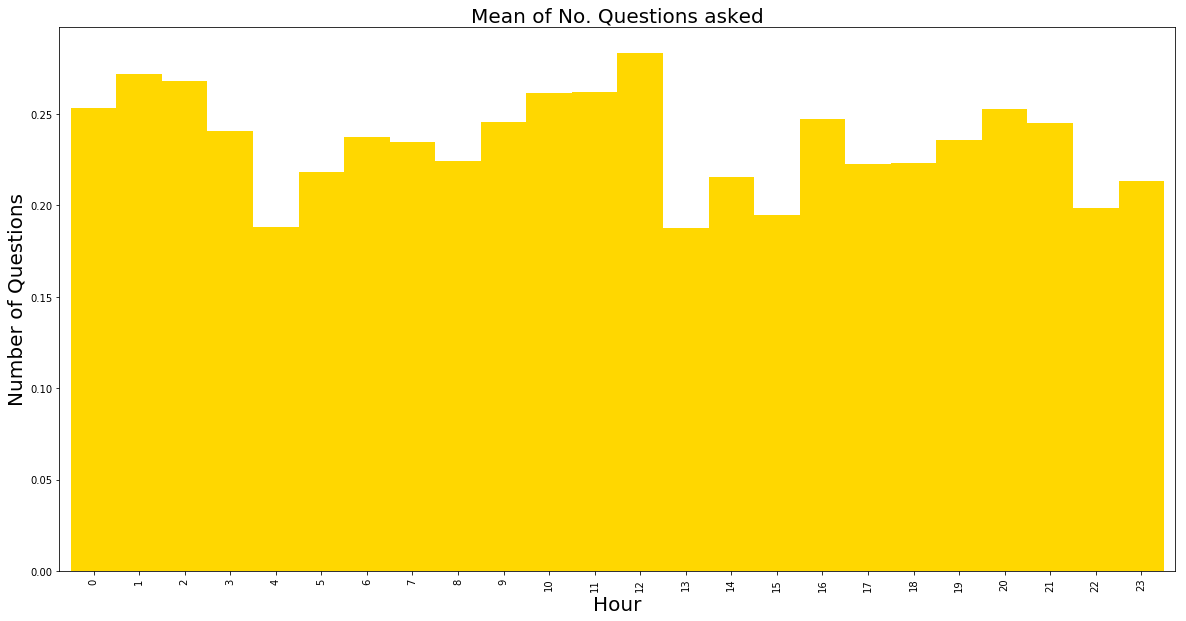

In [44]:
plt.title('Mean of No. Questions asked', fontsize=20)
chat_df.groupby(by='Hour').mean()['question_marks'].plot(figsize=(20,10), kind='bar', width=1, color='gold')
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Number of Questions', fontsize=20)

In [53]:
chat_df['issue number'].value_counts().head()

2394    13
3950    11
3826    10
1793     7
995      7
Name: issue number, dtype: int64